# Algorithme de PageRank

## Introduction 

En 2019, le nombre de sites Internet s'élève à plus 1,7 milliard, d'après les statistiques annuelles obtenues par NetCraft et l'algorithme Worldmeters. Néanmoins, derrière ce chiffre impressionnant, le nombre de sites web considérés comme actifs ne s'élève qu'à moins de 200 millions.

Lorsque nous effectuons une recherche sur Google, on peut se demander comment Google classe les résultats de cette requête, au vu du grand nombre de données disponibles. En fait, il va utiliser une mesure de la qualité ou de la popularité des pages web (PageRank) pour classer les résultats par ordre de pertinence.

Le web peut être vu comme un graphe dirigé G(V,E) où les sommets V sont les pages web et les arcs E sont les hyperliens entre les pages. Les arcs partent de la page où se trouve le lien et vont vers la page indiquée. La présence d'un lien vers une certaine page constitue un "vote" en faveur de cette page. Le PageRank est donc une mesure de l'importance relative d'une page sur le web. Cette valeur est basée sur plusieurs principes : 
- Les pages recevant plus de liens sont plus importantes 
- Un lien en provenance d'une page " importante" est plus significatif qu'un lien en provenance d'une page peu importante 
- Si une page contient beaucoup de liens, chaque lien a moins de valeur. 

Plus formellement, le PageRank P de la page n est défini de la façon suivante : <br/>
$$ P(n) = \alpha ( \frac{1}{|G|} ) + (1-\alpha) \sum_{m \in L(n) } \frac{P(m)}{C(m)}$$

où |G| est le nombre total de noeuds ( ou de pages) dans le graphe,  <br/>
 $\alpha$ est le facteur aléatoire de "saut", <br/>
 L(n) est l'ensemble des pages liées à n , <br/>
 C(m) est le nombre de liens sur la page m, <br/>
 
Dans ce sens, l'ensemble des PageRank des L(n) pages vont altérer le PageRank de n. En effet, en étant sur une page m de L(n), la probabilité d'arriver sur la page n est de $\frac{1}{C(m)}$. Puisque le PageRank de m est la probabilité d'être en m, la probabilité d'arriver à n en étant à m est de $\frac{P(m)}{C(m)}$

https://medium.com/analytics-vidhya/how-google-search-works-page-rank-algorithm-using-python-9643d9c9a981
https://towardsdatascience.com/pagerank-3c568a7d2332

In [4]:
# Packages utilisés 

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
import random as rd

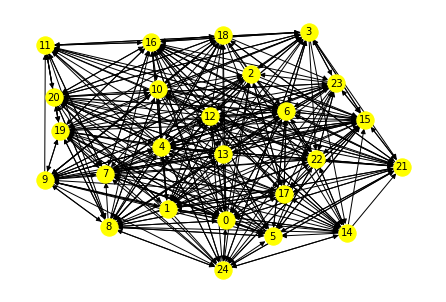

In [307]:
# Création d'un graphe orienté 
n = 25 # nombre de noeuds
p = 0.6 # probabilité de lien
graph=nx.gnp_random_graph(n,p,directed=True)
# Affichage du graphe
nx.draw(graph,with_labels=True,font_color='black',font_size=10,node_color='yellow')
plt.show()

In [269]:
graph

In [50]:
# Nombre de noeuds 
count=graph.number_of_nodes()
# Voisins du noeud 1
print(list(graph.neighbors(1)))

[0, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 18, 19, 21, 23]


In [51]:
count

25

In [53]:
#Page Rank Algorithm-Calculating random walk score
#initialising the dictionary which contains key as node and value as random walk score
rank_dict={}
# taking a random node as the starting node:
x=rd.randint(0,n)
#Setting random walk score of each node to zero
for j in range(0,n):
  rank_dict[j]=0
#Incrementing score of starting node
rank_dict[x]=rank_dict[x]+1
#iterating process for 50000 times and updating score
for i in range(500000):
  #storing list of neighboring nodes in list
  list_n=list(graph.neighbors(x))
  #if length of list is zero then taking another node and process starts
  if(len(list_n)==0):
    x=rd.randint(0,n)
    rank_dict[x]=rank_dict[x]+1
  #else choose any node from the list and continue the process by updating score to that node
  else:
    x=rd.choice(list_n)
    rank_dict[x]=rank_dict[x]+1
print("Random Walk Score Updated")

Random Walk Score Updated


In [54]:
#normalising values
for j in range(0,n):
  rank_dict[j]=rank_dict[j]/500000

In [55]:
rank_dict

{0: 0.030828,
 1: 0.047396,
 2: 0.043412,
 3: 0.034,
 4: 0.03079,
 5: 0.042812,
 6: 0.04084,
 7: 0.039458,
 8: 0.035236,
 9: 0.042634,
 10: 0.037814,
 11: 0.040456,
 12: 0.047516,
 13: 0.043512,
 14: 0.04244,
 15: 0.035474,
 16: 0.038122,
 17: 0.042482,
 18: 0.056932,
 19: 0.036508,
 20: 0.04289,
 21: 0.052518,
 22: 0.034102,
 23: 0.027198,
 24: 0.034632}

In [56]:
#Page rank by networkx library
pagerank=nx.pagerank(graph)
#sorting both dictionaries based on items
pagerank_sorted=sorted(pagerank.items(),key=lambda v:(v[1],v[0]),reverse=True)

In [57]:
#sorting the rank_dict based on values
rank_dict_sorted=sorted(rank_dict.items(),key=lambda v:(v[1],v[0]),reverse=True)

In [58]:
rank_dict_sorted

[(18, 0.056932),
 (21, 0.052518),
 (12, 0.047516),
 (1, 0.047396),
 (13, 0.043512),
 (2, 0.043412),
 (20, 0.04289),
 (5, 0.042812),
 (9, 0.042634),
 (17, 0.042482),
 (14, 0.04244),
 (6, 0.04084),
 (11, 0.040456),
 (7, 0.039458),
 (16, 0.038122),
 (10, 0.037814),
 (19, 0.036508),
 (15, 0.035474),
 (8, 0.035236),
 (24, 0.034632),
 (22, 0.034102),
 (3, 0.034),
 (0, 0.030828),
 (4, 0.03079),
 (23, 0.027198)]

In [59]:
#display the order 
print("The order generated by our implementation algorithm is\n") 
for i in rank_dict_sorted:
  print(i[0],end=" ")
print("\n\nThe order generated by networkx library is\n") 
for i in pagerank_sorted:
  print(i[0],end=" ")

The order generated by our implementation algorithm is

18 21 12 1 13 2 20 5 9 17 14 6 11 7 16 10 19 15 8 24 22 3 0 4 23 

The order generated by networkx library is

18 21 12 1 20 13 2 17 9 5 14 11 6 7 16 10 19 15 24 8 3 22 0 4 23 

In [ ]:
# https://www.geeksforgeeks.org/page-rank-algorithm-implementation/
# Un autre algorithm de PageRank possible : 

def pagerank(G, alpha=0.85, personalization=None,
             max_iter=100, tol=1.0e-6, nstart=None, weight='weight',
             dangling=None):
    """Return the PageRank of the nodes in the graph.
 
    PageRank computes a ranking of the nodes in the graph G based on
    the structure of the incoming links. It was originally designed as
    an algorithm to rank web pages.
 
    Parameters
    ----------
    G : graph
      A NetworkX graph.  Undirected graphs will be converted to a directed
      graph with two directed edges for each undirected edge.
 
    alpha : float, optional
      Damping parameter for PageRank, default=0.85.
 
    personalization: dict, optional
      The "personalization vector" consisting of a dictionary with a
      key for every graph node and nonzero personalization value for each node.
      By default, a uniform distribution is used.
 
    max_iter : integer, optional
      Maximum number of iterations in power method eigenvalue solver.
 
    tol : float, optional
      Error tolerance used to check convergence in power method solver.
 
    nstart : dictionary, optional
      Starting value of PageRank iteration for each node.
 
    weight : key, optional
      Edge data key to use as weight.  If None weights are set to 1.
 
    dangling: dict, optional
      The outedges to be assigned to any "dangling" nodes, i.e., nodes without
      any outedges. The dict key is the node the outedge points to and the dict
      value is the weight of that outedge. By default, dangling nodes are given
      outedges according to the personalization vector (uniform if not
      specified). This must be selected to result in an irreducible transition
      matrix (see notes under google_matrix). It may be common to have the
      dangling dict to be the same as the personalization dict.
 
    Returns
    -------
    pagerank : dictionary
       Dictionary of nodes with PageRank as value
 
    Notes
    -----
    The eigenvector calculation is done by the power iteration method
    and has no guarantee of convergence.  The iteration will stop
    after max_iter iterations or an error tolerance of
    number_of_nodes(G)*tol has been reached.
 
    The PageRank algorithm was designed for directed graphs but this
    algorithm does not check if the input graph is directed and will
    execute on undirected graphs by converting each edge in the
    directed graph to two edges.
 
     
    """
    if len(G) == 0:
        return {}
 
    if not G.is_directed():
        D = G.to_directed()
    else:
        D = G
 
    # Create a copy in (right) stochastic form
    W = nx.stochastic_graph(D, weight=weight)
    N = W.number_of_nodes()
 
    # Choose fixed starting vector if not given
    if nstart is None:
        x = dict.fromkeys(W, 1.0 / N)
    else:
        # Normalized nstart vector
        s = float(sum(nstart.values()))
        x = dict((k, v / s) for k, v in nstart.items())
 
    if personalization is None:
 
        # Assign uniform personalization vector if not given
        p = dict.fromkeys(W, 1.0 / N)
    else:
        missing = set(G) - set(personalization)
        if missing:
            raise NetworkXError('Personalization dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        s = float(sum(personalization.values()))
        p = dict((k, v / s) for k, v in personalization.items())
 
    if dangling is None:
 
        # Use personalization vector if dangling vector not specified
        dangling_weights = p
    else:
        missing = set(G) - set(dangling)
        if missing:
            raise NetworkXError('Dangling node dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        s = float(sum(dangling.values()))
        dangling_weights = dict((k, v/s) for k, v in dangling.items())
    dangling_nodes = [n for n in W if W.out_degree(n, weight=weight) == 0.0]
 
    # power iteration: make up to max_iter iterations
    for _ in range(max_iter):
        xlast = x
        x = dict.fromkeys(xlast.keys(), 0)
        danglesum = alpha * sum(xlast[n] for n in dangling_nodes)
        for n in x:
 
            # this matrix multiply looks odd because it is
            # doing a left multiply x^T=xlast^T*W
            for nbr in W[n]:
                x[nbr] += alpha * xlast[n] * W[n][nbr][weight]
            x[n] += danglesum * dangling_weights[n] + (1.0 - alpha) * p[n]
 
        # check convergence, l1 norm
        err = sum([abs(x[n] - xlast[n]) for n in x])
        if err < N*tol:
            return x
    raise NetworkXError('pagerank: power iteration failed to converge '
                        'in %d iterations.' % max_iter)
    


In [16]:
G=nx.barabasi_albert_graph(20000,41)
# nx.draw(G,with_labels=True,font_color='black',font_size=10,node_color='yellow')
# plt.show()

In [17]:
pr=nx.pagerank(G,0.4)
pr

{0: 0.0001184017000213509,
 1: 0.00015589016612662133,
 2: 0.00016663828614708344,
 3: 0.00022980061261412658,
 4: 0.0001732023212569463,
 5: 0.00017251351107883833,
 6: 0.00015309253323221448,
 7: 0.00013619275055111647,
 8: 0.00016150989287889924,
 9: 0.00024111703617942014,
 10: 0.0001767070149993043,
 11: 0.00013184952360210342,
 12: 0.0001512847882962431,
 13: 0.00018075811296146163,
 14: 0.00012635616125040606,
 15: 0.00016908559045150163,
 16: 0.00011937834991422877,
 17: 0.0002125564865991689,
 18: 0.00020780823915070076,
 19: 0.00013722668570641673,
 20: 0.0002076859246584297,
 21: 0.0002693426028203319,
 22: 0.0001489841560073751,
 23: 0.00013658104457161722,
 24: 0.0001944478533765961,
 25: 0.00017204441961366813,
 26: 0.00019408534291684958,
 27: 0.00016117481052730024,
 28: 0.00015073196684543163,
 29: 0.00017995877105494125,
 30: 0.00017854694897668897,
 31: 0.00021000771015054886,
 32: 0.00021329118683805526,
 33: 0.00011440033209290057,
 34: 0.00015101123991084905,
 35:

In [18]:
pr_sorted=sorted(pr.items(),key=lambda v:(v[1],v[0]),reverse=True)
pr_sorted

[(41, 0.00043834090705792764),
 (44, 0.00038279677569565335),
 (42, 0.0003818744990910768),
 (46, 0.00037519265382419205),
 (43, 0.0003682262706092518),
 (45, 0.0003658851464016048),
 (51, 0.00036434900036605916),
 (47, 0.0003607482524594192),
 (50, 0.00035579329091051),
 (60, 0.00035356180797670606),
 (59, 0.0003301071417589343),
 (48, 0.00032914054037101633),
 (64, 0.0003223439545920169),
 (53, 0.00032084981457610487),
 (67, 0.00032068056816138307),
 (49, 0.0003168583145094832),
 (74, 0.00031359234370693397),
 (56, 0.00031354796915686805),
 (61, 0.00031219536578708),
 (57, 0.0003094120839893886),
 (55, 0.000305985831210133),
 (65, 0.00030490655750301204),
 (71, 0.00030180399719265545),
 (63, 0.0003015070115653255),
 (62, 0.00029738037920766963),
 (52, 0.0002927923602547403),
 (68, 0.00029135225474676577),
 (54, 0.0002813862002931249),
 (75, 0.00027957404864272856),
 (70, 0.00027286894315631217),
 (58, 0.0002710405389644651),
 (84, 0.0002701062336709502),
 (21, 0.0002693426028203319),

# Proposition de plan : 

## 0 : Introduction 


## 1 : PageRank 
- Explication formelle/algébrique 
- Implémentation d'un algo + explications 
- Complexité de l'algo : Où est ce que ça demande un temps de calcul long ( --> Multiplication de matrice --> Sol : MapReduce )


## 2 : MapReduce 
- Explication formelle/algébrique de MapREduce en général 
- Comment ça va simplifier notre algo de PageRank ?
- Implémentation d'un algo + explications 
- Complexité de l'algo + comparaison avec celui du dessous 


## 3 : Application 
- 1 ou 2 jeux de données : le premier en petite dimension où le premier algo est efficace, puis un second jeu de données en grande dimension, où le premier algo peine à converger --> intêter de MapReduce 
- Vraie problématique + interprétation du score PageRank 

Lien pas mal avec une explication algébrique du PageRank: https://hippocampus-garden.com/pagerank/



https://hippocampus-garden.com/pagerank/


https://michaelnielsen.org/blog/using-mapreduce-to-compute-pagerank/

In [1]:
import numpy as np
from numpy import * 
import numpy
import random
import matplotlib.pyplot as plt
import time
# from scipy import special 

### Etape 1 : Modélisation du web 
On veut que le web soit modélisé de la sorte à ce que chaque page soit associée à d'autres pages par un dictionnaire
Puisque les pages n'ont pas forcement de lien entre elles, la matrice de liaison est composée de multiples 0. On veut donc une distribution de probabilité qui favorise la valeur 0. On selectionne random.zipf en le tronquant à n ( taille de la population ) pour que le nombre de pages liées à la page k ne puisse pas être plus grand que le nombre de pages total.

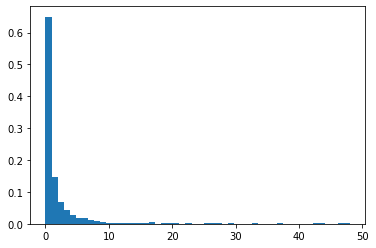

In [2]:
a = 2. # parameter
s = np.random.zipf(a, 1000)-1
count, bins, ignored = plt.hist(s[s<50], 50, density=True)
plt.show()

In [3]:
class web:
    def __init__(self,n):
        self.size = n
        self.in_links = {}
        self.number_out_links = {}
        self.dangling_pages = {}
        for j in range(n):
            self.in_links[j] = []
            self.number_out_links[j] = 0
            self.dangling_pages[j] = True
        self.matrixG = np.zeros((n,n)) 


def random_web(n=1000):
    '''Fonction de modélisation du web'''
    g = web(n)
    for k in range(n):
        #print('k',k)
        # Nombre aléatoire de liens qui se référent à la page k :
        number_link_k = min(numpy.random.zipf(2)-1,n) # min pour ne pas obtenir d'échantillon plus grand que l'ensemble de la population
        # Nom des pages qui se référent à la page k
        values = random.sample(range(n),number_link_k)
        # Pages qui citent k 
        g.in_links[k] = values
        # mise à jour de la matrice représentative du web
        for j in values: 
            # mise à jour de la matrice représentative du web
            g.matrixG[j,k]=1
            # mise à jour des dangling pages
            if g.number_out_links[j] == 0: 
                g.dangling_pages.pop(j)
            # mise à jour du nombre de liens de sortie
            g.number_out_links[j] += 1
    return g

### Etape 2 : Algorithmes de PageRank simples

In [39]:
g=random_web(5000)

In [40]:
def get_matrice (g):
    '''
    Description matricielle du web, avec les poids de chaque page. 
    
    Input : 
        - g de type web
        
    Output : 
        - G : matrice représentative du web
        
    Exemple : 
        - g=random_web(5)
        - g.in_links 
        >>> {0: [3, 0, 4, 2, 1], 1: [0], 2: [], 3: [], 4: []}
        - get_matrice(g)
        >>> array([[0.5, 0.5, 0. , 0. , 0. ],
                   [1. , 0. , 0. , 0. , 0. ],
                   [1. , 0. , 0. , 0. , 0. ],
                   [1. , 0. , 0. , 0. , 0. ],
                   [1. , 0. , 0. , 0. , 0. ]])
    
    '''
    A = g.matrixG.copy()
    # On adapte pour les noeuds qui n'ont pas de sortie ( sinon division par 0 ): 
    is_dangling= np.sum(A, axis=1)==0
    # Noeuds sans sortie : le web surfeur se téléporte vers une autre noeud de façon aléatoire : 
    B = (np.ones_like(A) - np.identity(g.size)) / (g.size-1) 
    A[is_dangling,:] += B[is_dangling,:]
    # Attribution des poids
    D_inv= np.diag(1/np.sum(A, axis=1))
    G=D_inv@A
    return G
get_matrice(g)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Soit n pages et p = ($p_1$ , ... , $p_n$ ) la distribution de probabilité des pages.

Soit G la matrise de représentation des liens aléatoires entre les pages ( donnée par la fonction get_matrice () ). 
$$
G_{jk} = \begin{cases} \frac{1}{\#(k)}, & \text{si la page k est liée à la page j} \\ 0, & \text { si la page k n'est pas liée à la page j }   \end{cases}
$$
On suppose que si la page k n'a aucun lien de sortie ( dangling node ) alors le web surfeur ira sur n'importe quelle autre page avec probabilité $\frac{1}{n}$. C'est à dire $G_{jk} = \frac{1}{n} $ pour tout j.

La matrice E représente la matrice de téléportation. Elle téléporte le websurfer de la page k à la page j avec probabilité $\frac{1}{n}$. C'est à dire $E_{jk} =\frac{1}{n}$. 

Le websurfer a donc deux possibilité : 
- Avec probabilité s, il suit un lien aléatoire depuis la page où il se trouve, 
- Avec probabilité d = 1-s, il change totalement de chemin en se téléportant vers une autre page. 

Comme dans le papier initial de la publication de PageRank, on choisira s = 0,85 et d = 0,15. 

Après une étape on arrive donc à : 
M = sG + dE

#### Algorithme 1 : Décomposition en valeurs propres

D'après le Théorème de Perron Frobenius ( preuve ici https://sites.math.northwestern.edu/~clark/354/2002/perron.pdf ), la matrice M est à coefficients positifs et type n $\times$ n et est irréductible. Alors les propriétés suivantes sont valables : 
- M a une valeur propre 1 de multiplicité 1 
- 1 est la plus grande valeur propre 
- Pour la valeur propre 1, il existe un unique vecteur propre où la somme de ses composants est égale à 1

De ce fait, on a juste à calculer le vecteur propre de la valeur propre 1 pour obtenir le score PageRank. 

In [41]:
def pagerank_vp(g, d=0.15):
    loopStartTime = time.time()
    G = get_matrice(g).T
    E= np.ones((g.size,g.size))/g.size
    M = (1-d)*G + d*E
    #Décomposition en valeurs propres et vecteurs propres 
    eigenvalues, eigenvectors = np.linalg.eig(M)
    # Récupération de l'index de la plus grande valeur popre
    idx = eigenvalues.argsort()[-1] 
    # Récupération du vecteur propre associé 
    largest = np.array(eigenvectors[:,idx]).flatten().real
    # On normalise pour que la somme soit égale à 1 
    PageRank = largest / np.sum(np.abs(largest))
    loopEndTime = time.time()
    print("PageRank vp Loop time is: " + str( loopEndTime - loopStartTime) + " s.\n")
    return PageRank

In [ ]:
pagerank_vp(g)

#### Algorithme 2 :
On peut trouver le score Page Rank d'une autre méthode. 
On peut définir la distribution PageRank, q, comme la distribution de probabilité inchangée par une marche aléatoire : q = Mq.

Soit M = sG + TE. 
Alors l'équation Mq = q est équivalente à (I-sG)q = tEq


In [ ]:
def pagerank1 (g , d = 0.15) : 
    loopStartTime = time.time()
    G = get_matrice(g).T
    I = mat(eye(g.size)) # Matrice identité
    # Vecteur de téléportation
    P = (1.0/g.size)*mat(ones((g.size,1)))
    s = 1-d
    # compute the PageRank vector 
    PageRank = d*((I-s*G).I)*P     
    loopEndTime = time.time()
    print("PageRank1 Loop time is: " + str( loopEndTime - loopStartTime) + " s.\n")
    return PageRank

In [ ]:
pagerank1(g)

In [8]:
g.matrixG

array([[1., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [7]:
(1.0/g.size)*mat(ones((g.size,1)))

matrix([[0.2],
        [0.2],
        [0.2],
        [0.2],
        [0.2]])

In [9]:
np.ones((g.size,g.size))/g.size

array([[0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2]])

In [17]:
pagerank_edc(g)

PageRank1 Loop time is: 0.0 s.



array([0.06326087, 0.05217391, 0.05217391, 0.78021739, 0.05217391])

In [458]:
import networkx as nx
import numpy as np

def get_google_matrix(G, d=0.15):
    n = G.number_of_nodes()
    A = nx.to_numpy_array(G).T
    # for sink nodes
    is_sink = np.sum(A, axis=0)==0
    B = (np.ones_like(A) - np.identity(n)) / (n-1)
    A[:, is_sink] += B[:, is_sink]
    
    D_inv = np.diag(1/np.sum(A, axis=0))
    M = np.dot(A, D_inv) 
    
    # for disconnected components
    M = (1-d)*M + d*np.ones((n,n))/n
    return M

def l1(x):
    return np.sum(np.abs(x))

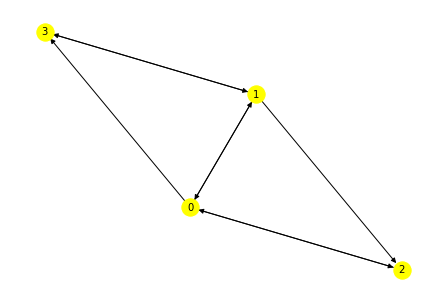

In [53]:
# Création d'un graphe orienté 
n = 4# nombre de noeuds
p = 0.6 # probabilité de lien
graph=nx.gnp_random_graph(n,p,directed=True)
# Affichage du graphe
nx.draw(graph,with_labels=True,font_color='black',font_size=10,node_color='yellow')
plt.show()

In [54]:
A = nx.to_numpy_array(graph)
A

array([[0., 1., 1., 1.],
       [1., 0., 1., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [470]:
is_sink = np.sum(A, axis=0)==0
B = (np.ones_like(A) - np.identity(n)) / (n-1)
B
A[:, is_sink] += B[:, is_sink]

In [471]:
A

array([[0., 0., 1., 0.],
       [1., 0., 0., 1.],
       [0., 1., 0., 1.],
       [1., 1., 1., 0.]])

In [465]:
get_google_matrix(graph)

array([[0.0375, 0.0375, 0.4625, 0.0375],
       [0.4625, 0.0375, 0.0375, 0.4625],
       [0.0375, 0.4625, 0.0375, 0.4625],
       [0.4625, 0.4625, 0.4625, 0.0375]])

In [456]:
def pagerank_edc(G, d=0.15):
    M = get_google_matrix(G, d=d)
    eigenvalues, eigenvectors = np.linalg.eig(M)
    idx = eigenvalues.argsort()[-1]
    largest = np.array(eigenvectors[:,idx]).flatten().real
    return largest / l1(largest)

In [459]:
pagerank_edc(graph)

array([0.10359322, 0.09969254, 0.12487389, 0.09275067, 0.09883476,
       0.1055305 , 0.09068577, 0.06956095, 0.09213139, 0.1223463 ])

In [279]:
def pagerank(g,s=0.85,tolerance=0.00001):
    '''Returns the PageRank vector for the web g and
    parameter s, where the criterion for convergence is that
    we stop when M^(j+1)P-M^jP has length less than
    tolerance, in l1 norm.'''
    n = g.size
    p = numpy.matrix(numpy.ones((n,1)))/n
    iteration = 1
    change = 2
    loopStartTime = time.time()
    while change > tolerance:
        print ("Iteration: %s" % iteration)
        new_p = step(g,p,s)
        change = numpy.sum(numpy.abs(p-new_p))
        print ("Change in l1 norm: %s" % change)
        p = new_p
        iteration += 1
    loopEndTime = time.time()
    print("PageRank Loop time is: " + str( loopEndTime - loopStartTime) + " s.\n")
    return p

In [272]:
import numpy
import random
import time

class web:
  def __init__(self,n):
    self.size = n
    self.in_links = {}
    self.number_out_links = {}
    self.dangling_pages = {}
    for j in range(n):
      self.in_links[j] = []
      self.number_out_links[j] = 0
      self.dangling_pages[j] = True

def paretosample(n,power=2.0):
    '''Returns a sample from a truncated Pareto distribution
    with probability mass function p(l) proportional to
    1/l^power.  The distribution is truncated at l = n.'''
    m = n+1
    while m > n: m = numpy.random.zipf(power)
    return m

def random_web(n=1000,power=2.0):
    '''Returns a web object with n pages, and where each
  page k is linked to by L_k random other pages.  The L_k
  are independent and identically distributed random
  variables with a shifted and truncated Pareto
  probability mass function p(l) proportional to
  1/(l+1)^power.'''
    g = web(n)
    for k in range(n):
        lk = paretosample(n+1,power)-1
        values = random.sample(range(n),lk)
        g.in_links[k] = values
        for j in values: 
            if g.number_out_links[j] == 0: g.dangling_pages.pop(j)
            g.number_out_links[j] += 1
    return g

def step(g,p,s=0.85):
  '''Performs a single step in the PageRank computation,
  with web g and parameter s.  Applies the corresponding M
  matrix to the vector p, and returns the resulting
  vector.'''
  n = g.size
  v = numpy.matrix(numpy.zeros((n,1)))
  inner_product = sum([p[j] for j in g.dangling_pages.keys()])
  for j in range(n):
    v[j] = s*sum([p[k]/g.number_out_links[k] 
    for k in g.in_links[j]])+s*inner_product/n+(1-s)/n
  # We rescale the return vector, so it remains a
  # probability distribution even with floating point
  # roundoff.
  return v/numpy.sum(v)  

def pagerank(g,s=0.85,tolerance=0.00001):
    '''Returns the PageRank vector for the web g and
    parameter s, where the criterion for convergence is that
    we stop when M^(j+1)P-M^jP has length less than
    tolerance, in l1 norm.'''
    n = g.size
    p = numpy.matrix(numpy.ones((n,1)))/n
    iteration = 1
    change = 2
    loopStartTime = time.time()
    while change > tolerance:
        print ("Iteration: %s" % iteration)
        new_p = step(g,p,s)
        change = numpy.sum(numpy.abs(p-new_p))
        print ("Change in l1 norm: %s" % change)
        p = new_p
        iteration += 1
    loopEndTime = time.time()
    print("PageRank Loop time is: " + str( loopEndTime - loopStartTime) + " s.\n")
    return p

print ('''Now computing the PageRank vector for a random
web containing 10000 pages, with the number of inbound
links to each page controlled by a Pareto power law
distribution with parameter 2.0, and with the criterion
for convergence being a change of less than 0.0001 in l1
norm over a matrix multiplication step.''')

g = random_web(100000,2.0) # works up to several million
                          # pages.
pr = pagerank(g,0.85,0.0001)

Now computing the PageRank vector for a random
web containing 10000 pages, with the number of inbound
links to each page controlled by a Pareto power law
distribution with parameter 2.0, and with the criterion
for convergence being a change of less than 0.0001 in l1
norm over a matrix multiplication step.
Iteration: 1
Change in l1 norm: 1.3709271942714303
Iteration: 2
Change in l1 norm: 0.5073848017501931
Iteration: 3
Change in l1 norm: 0.22153968437124327
Iteration: 4
Change in l1 norm: 0.0941074680864278
Iteration: 5
Change in l1 norm: 0.03886234334334523
Iteration: 6
Change in l1 norm: 0.015753416999146497
Iteration: 7
Change in l1 norm: 0.0062518674599835785
Iteration: 8
Change in l1 norm: 0.0024769064176170365
Iteration: 9
Change in l1 norm: 0.0009555846687940857
Iteration: 10
Change in l1 norm: 0.00037139680186541523
Iteration: 11


KeyboardInterrupt: 

In [232]:
g=random_web()

In [235]:
print(g.number_out_links )

{0: 3, 1: 2, 2: 4, 3: 5, 4: 2, 5: 10, 6: 4, 7: 4, 8: 1, 9: 2, 10: 6, 11: 4, 12: 2, 13: 4, 14: 3, 15: 4, 16: 3, 17: 4, 18: 4, 19: 3, 20: 3, 21: 3, 22: 5, 23: 5, 24: 3, 25: 3, 26: 4, 27: 5, 28: 4, 29: 2, 30: 6, 31: 6, 32: 2, 33: 5, 34: 2, 35: 3, 36: 4, 37: 4, 38: 3, 39: 4, 40: 4, 41: 4, 42: 5, 43: 5, 44: 3, 45: 6, 46: 6, 47: 4, 48: 4, 49: 5, 50: 4, 51: 1, 52: 4, 53: 3, 54: 1, 55: 5, 56: 4, 57: 1, 58: 4, 59: 4, 60: 4, 61: 6, 62: 9, 63: 2, 64: 4, 65: 5, 66: 3, 67: 10, 68: 6, 69: 4, 70: 3, 71: 3, 72: 7, 73: 2, 74: 4, 75: 4, 76: 6, 77: 4, 78: 3, 79: 5, 80: 5, 81: 5, 82: 6, 83: 5, 84: 4, 85: 4, 86: 6, 87: 5, 88: 5, 89: 4, 90: 5, 91: 5, 92: 1, 93: 6, 94: 3, 95: 3, 96: 2, 97: 2, 98: 3, 99: 6, 100: 3, 101: 4, 102: 3, 103: 4, 104: 5, 105: 4, 106: 3, 107: 3, 108: 5, 109: 3, 110: 3, 111: 6, 112: 6, 113: 3, 114: 4, 115: 4, 116: 7, 117: 5, 118: 5, 119: 6, 120: 6, 121: 3, 122: 1, 123: 3, 124: 4, 125: 6, 126: 7, 127: 1, 128: 5, 129: 6, 130: 5, 131: 6, 132: 3, 133: 6, 134: 6, 135: 4, 136: 6, 137: 2, 138

In [33]:
import itertools
import time


def map_reduce(i,mapper,reducer):
    intermediate = []
    for (key,value) in i.items():
        intermediate.extend(mapper(key,value))
    groups = {}
    for key, group in itertools.groupby(sorted(intermediate), lambda x: x[0]):
        groups[key] = list([y for x, y in group])
    return [reducer(intermediate_key,groups[intermediate_key]) for intermediate_key in groups] 

In [34]:
# Modélisation du web :
import numpy.random
import random

def paretosample(n,power=2.0):
    # Returns a sample from a truncated Pareto distribution
    # with probability mass function p(l) proportional to
    # 1/l^power.  The distribution is truncated at l = n.
    m = n+1
    while m > n: m = numpy.random.zipf(power)
    return m

def initialize(n,power):
    # Returns a Python dictionary representing a web
    # with n pages, and where each page k is linked to by
    # L_k random other pages.  The L_k are independent and
    # identically distributed random variables with a
    # shifted and truncated Pareto probability mass function
    # p(l) proportional to 1/(l+1)^power.
    
    # The representation used is a Python dictionary with
    # keys 0 through n-1 representing the different pages.
    # i[j][0] is the estimated PageRank, initially set at 1/n,
    # i[j][1] the number of outlinks, and i[j][2] a list of
    # the outlinks.
    
    # This dictionary is used to supply (key,value) pairs to
    # both mapper tasks defined below.
    
    # initialize the dictionary
    i = {} 
    for j in range(n): i[j] = [1.0/n,0,[]]
        # For each page, generate inlinks according to the Pareto
        # distribution. Note that this is somewhat tedious, because
        # the Pareto distribution governs inlinks, NOT outlinks,
        # which is what our representation is adapted to represent.
        # A smarter representation would give easy
        # access to both, while remaining memory efficient.
    for k in range(n):
        lk = paretosample(n+1,power)-1
        values = random.sample(range(n),lk)
        for j in values:
            i[j][1] += 1 # increment the outlink count for page j
            i[j][2].append(k) # insert the link from j to k
    return i

def ip_mapper(input_key,input_value):
  # The mapper used to compute the inner product between
  # the vector of dangling pages and the current estimated
  # PageRank.  The input is a key describing a webpage, and
  # the corresponding data, including the estimated pagerank.
  # The mapper returns [(1,pagerank)] if the page is dangling,
  # and otherwise returns nothing.
  
  if input_value[1] == 0: return [(1,input_value[0])]
  else: return []

def ip_reducer(input_key,input_value_list):
  # The reducer used to compute the inner product.  Simply
  # sums the pageranks listed in the input value list, which
  # are all the pageranks for dangling pages.

  return sum(input_value_list)

def pr_mapper(input_key,input_value):
  # The mapper used to update the PageRank estimate.  Takes
  # as input a key for a webpage, and as a value the corresponding
  # data, as described in the function initialize.  It returns a
  # list with all outlinked pages as keys, and corresponding values
  # just the PageRank of the origin page, divided by the total
  # number of outlinks from the origin page.  Also appended to
  # that list is a pair with key the origin page, and value 0.
  # This is done to ensure that every single page ends up with at
  # least one corresponding (intermediate_key,intermediate_value)
  # pair output from a mapper.
  
  return [(input_key,0.0)]+[(outlink,input_value[0]/input_value[1])
          for outlink in input_value[2]]

def pr_reducer_inter(intermediate_key,intermediate_value_list,
                     s,ip,n):
  # This is a helper function used to define the reducer used
  # to update the PageRank estimate.  Note that the helper differs
  # from a standard reducer in having some additional inputs:
  # s (the PageRank parameter), ip (the value of the inner product
  # between the dangling pages vector and the estimated PageRank),
  # and n, the number of pages.  Other than that the code is
  # self-explanatory.
  
  return (intermediate_key,
          s*sum(intermediate_value_list)+s*ip/n+(1.0-s)/n)

def pagerank(i,s=0.85,tolerance=0.00001):
    # Returns the PageRank vector for the web described by i,
    # using parameter s.  The criterion for convergence is that
    # we stop when M^(j+1)P-M^jP has length less than tolerance,
    # in l1 norm.
    loopStartTime = time.time()
    n = len(i)
    iteration = 1
    change = 2 # initial estimate of error
    while change > tolerance:
        print ("Iteration: "+str(iteration))
        # Run the MapReduce job used to compute the inner product
        # between the vector of dangling pages and the estimated
        # PageRank.
        ip_list = map_reduce(i,ip_mapper,ip_reducer)

    # the if-else clause is needed in case there are no dangling
    # pages, in which case MapReduce returns ip_list as the empty
    # list.  Otherwise, set ip equal to the first (and only)
    # member of the list returned by MapReduce.
        if ip_list == []: ip = 0
        else: ip = ip_list[0]

    # Dynamically define the reducer used to update the PageRank
    # vector, using the current values for s, ip, and n.
        pr_reducer = lambda x,y: pr_reducer_inter(x,y,s,ip,n)

    # Run the MapReduce job used to update the PageRank vector.
        new_i = map_reduce(i,pr_mapper,pr_reducer)

    # Compute the new estimate of error.
        change = sum([abs(new_i[j][1]-i[j][0]) for j in range(n)])
        print ("Change in l1 norm: "+str(change))

    # Update the estimate PageRank vector.
        for j in range(n): i[j][0] = new_i[j][1]
        iteration += 1
    loopEndTime = time.time()
    print("PageRank Loop time is: " + str( loopEndTime - loopStartTime) + " s.\n")
    return i

n = 100000 # works up to about 1000000 pages
i = initialize(n,2.0)
new_i = pagerank(i,0.85,0.0001)

Iteration: 1
Change in l1 norm: 1.3581796850058148
Iteration: 2
Change in l1 norm: 0.512365563413025
Iteration: 3
Change in l1 norm: 0.22396617286661047
Iteration: 4
Change in l1 norm: 0.1011607952299007
Iteration: 5
Change in l1 norm: 0.04409794264154801
Iteration: 6
Change in l1 norm: 0.01863674134546172
Iteration: 7
Change in l1 norm: 0.007721056035467902
Iteration: 8
Change in l1 norm: 0.0030751703223903825
Iteration: 9
Change in l1 norm: 0.001239164836559148
Iteration: 10
Change in l1 norm: 0.0004985164577020728
Iteration: 11
Change in l1 norm: 0.00020084701487303624
Iteration: 12
Change in l1 norm: 7.991670306920073e-05
PageRank Loop time is: 13.47202444076538 s.



In [36]:
i

{0: [1.6339958717626226e-06, 5, [22005, 31061, 55097, 78297, 94111]],
 1: [1.6339958717626226e-06, 5, [22243, 37243, 44338, 47983, 55097]],
 2: [1.981218507238058e-06, 2, [32439, 88525]],
 3: [1.6339958717626226e-06, 1, [93050]],
 4: [1.6339958717626226e-06, 6, [5435, 22005, 33228, 35966, 54136, 82537]],
 5: [1.6339958717626226e-06, 6, [11399, 30162, 37616, 61775, 78670, 88675]],
 6: [1.8654776287462461e-06,
  8,
  [3521, 31240, 33417, 55097, 65689, 68559, 98809, 99220]],
 7: [5.817116520318256e-06, 3, [33228, 79860, 86365]],
 8: [1.6339958717626226e-06, 2, [40288, 57169]],
 9: [1.8654776287462461e-06, 5, [26509, 67648, 70087, 71123, 86365]],
 10: [1.6339958717626226e-06, 3, [21110, 71384, 86365]],
 11: [1.6339958717626226e-06, 3, [3471, 22829, 47983]],
 12: [1.9670228915620497e-06, 5, [22005, 72701, 75571, 79161, 93522]],
 13: [1.6339958717626226e-06, 4, [46343, 69782, 80992, 81972]],
 14: [1.6339958717626226e-06,
  8,
  [5909, 6010, 11371, 23346, 44341, 49933, 55097, 57169]],
 15: [2